In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from os.path import expanduser
import pickle
import random
import time

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
experiment_name = 'P3856_YHE211'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

# RESULTS_DIR = '/media/big-ssd/results-P3856'
# IDENTS_PASEF_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-20-02-44-34/identifications-pasef'.format(RESULTS_DIR)

IDENTS_PASEF_DIR = '{}/identifications-pasef'.format(EXPERIMENT_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.feather'.format(IDENTS_PASEF_DIR, experiment_name)

FEATURES_PASEF_DIR = '{}/features-pasef'.format(EXPERIMENT_DIR)
FEATURES_PASEF_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.feather'.format(FEATURES_PASEF_DIR, experiment_name, run_name)

In [4]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

In [5]:
input_names = ['deconvolution_score','coelution_coefficient','mobility_coefficient','isotope_count']

#### identified features

In [6]:
MAXIMUM_Q_VALUE = 0.01

In [7]:
# load the features identified
idents_df = pd.read_feather(IDENTS_PASEF_FILE)
idents_df = idents_df[(idents_df.run_name == run_name) & (idents_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()

In [8]:
idents_df['excluded'] = idents_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_df = idents_df[(idents_df.excluded == False)]

In [9]:
print('{} identifications'.format(len(idents_df)))

12447 identifications


#### detected features

In [10]:
# load the features detected by PASEF
features_df = pd.read_feather(FEATURES_PASEF_FILE)

In [11]:
features_df['excluded'] = features_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_df = features_df[(features_df.excluded == False)]

In [12]:
print('{} features detected'.format(len(features_df)))

67245 features detected


In [13]:
sets_d = {'detected':set(), 'identified':set()}

In [14]:
sets_d['detected'] = set(features_df.feature_id.tolist())
sets_d['identified'] = set(idents_df.feature_id.tolist()) - (set(idents_df.feature_id.tolist()) - set(features_df.feature_id.tolist()))

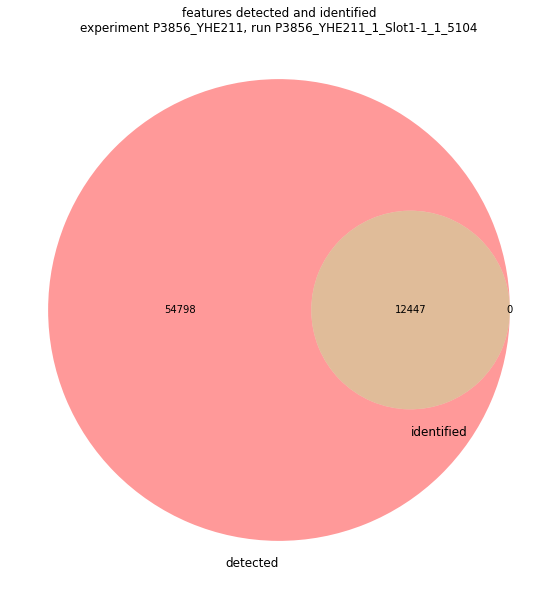

In [15]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features detected and identified\nexperiment {}, run {}'.format(experiment_name, run_name))

venn2([sets_d['detected'],sets_d['identified']], ('detected','identified'))

plt.show()

#### build the training set

In [16]:
# features detected but not identified
features_not_identified = sets_d['detected'] - sets_d['identified']
features_identified = sets_d['identified']

In [17]:
len(features_not_identified), len(features_identified)

(54798, 12447)

In [18]:
features_not_identified_df = features_df[features_df.feature_id.isin(features_not_identified)]
features_identified_df = features_df[features_df.feature_id.isin(features_identified)]

In [19]:
SAMPLE_SIZE = 8500

In [20]:
features_not_identified_df = features_not_identified_df.sample(n=SAMPLE_SIZE)
features_not_identified_df['category'] = 0

features_identified_df = features_identified_df.sample(n=SAMPLE_SIZE)
features_identified_df['category'] = 1

In [21]:
combined_df = pd.concat([features_not_identified_df, features_identified_df], axis=0, sort=False, ignore_index=True)

In [22]:
combined_df.isna().sum()

mono_mz_lower                               0
mono_mz_upper                               0
scan_apex                                   0
scan_lower                                  0
scan_upper                                  0
rt_apex                                     0
rt_lower                                    0
rt_upper                                    0
intensity_without_saturation_correction     0
intensity_with_saturation_correction        0
mono_intensity_adjustment_outcome           0
isotopic_peaks                              0
coelution_coefficient                      75
mobility_coefficient                       76
scan_df                                     0
rt_df                                       0
monoisotopic_mz                             0
charge                                      0
monoisotopic_mass                           0
feature_intensity                           0
envelope                                    0
isotope_count                     

In [23]:
combined_df.fillna(0, inplace=True)

In [24]:
feature_ids_l = combined_df.feature_id.tolist()

In [25]:
train_proportion = 0.8
val_proportion = 0.1

In [26]:
train_n = round(len(feature_ids_l) * train_proportion)
val_n = round(len(feature_ids_l) * val_proportion)

In [27]:
train_set = random.sample(feature_ids_l, train_n)
val_test_set = list(set(feature_ids_l) - set(train_set))
val_set = random.sample(val_test_set, val_n)
test_set = list(set(val_test_set) - set(val_set))

In [28]:
train_df = combined_df[combined_df.feature_id.isin(train_set)]
valid_df = combined_df[combined_df.feature_id.isin(val_set)]
test_df = combined_df[combined_df.feature_id.isin(test_set)]

In [29]:
train_df.to_pickle('{}/train_df.pkl'.format(expanduser('~')))
valid_df.to_pickle('{}/valid_df.pkl'.format(expanduser('~')))
test_df.to_pickle('{}/test_df.pkl'.format(expanduser('~')))

In [30]:
print('train: {} ({}%), validation: {} ({}%), test: {} ({}%)'.format(len(train_df), round(len(train_df)/len(combined_df)*100), len(test_df), round(len(test_df)/len(combined_df)*100), len(valid_df), round(len(valid_df)/len(combined_df)*100)))


train: 13600 (80%), validation: 1700 (10%), test: 1700 (10%)


In [31]:
X_train = train_df[input_names].to_numpy()
y_train = train_df[['category']].to_numpy()[:,0]

In [32]:
X_valid = valid_df[input_names].to_numpy()
y_valid = valid_df[['category']].to_numpy()[:,0]

In [33]:
X_test = test_df[input_names].to_numpy()
y_test = test_df[['category']].to_numpy()[:,0]

In [34]:
# define the keras model
model = Sequential()
model.add(BatchNormalization(input_shape=(4,)))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [35]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 4)                 16        
_________________________________________________________________
dense (Dense)                (None, 200)               1000      
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               8

In [37]:
# for visualisation
tf.keras.models.save_model(model, "{}/model.h5".format(expanduser('~')))

In [38]:
# fit the keras model on the dataset
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=4000, 
                    batch_size=512,
                    verbose=0)

best validation loss: 0.4402
best validation accuracy: 0.8035


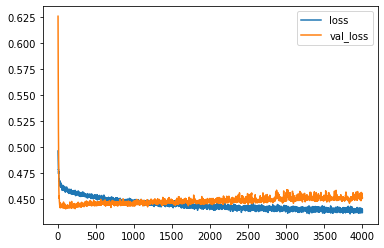

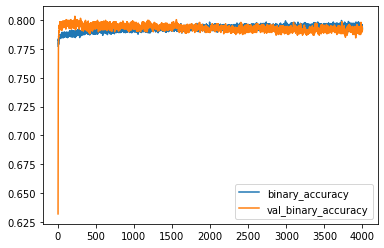

In [39]:
history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()
print(("best validation loss: {:0.4f}"+"\nbest validation accuracy: {:0.4f}").format(history_df['val_loss'].min(), history_df['val_binary_accuracy'].max()))

#### evaluate the model on the test data

In [40]:
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

14/14 [==============================] - 0s 2ms/step - loss: 0.4582 - binary_accuracy: 0.7953
test loss, test acc: [0.4581538736820221, 0.7952941060066223]


#### use the model to classify the 3DID features

In [41]:
experiment_name = 'P3856'
EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)
MODEL_DIR = '{}/features-3did-classifier'.format(EXPERIMENT_DIR)

#### save the model

In [42]:
model.save(MODEL_DIR)

INFO:tensorflow:Assets written to: /media/big-ssd/experiments/P3856/features-3did-classifier/assets
